# Clustering Euroleague Shooters

In this Notebook we are gonna learn how to use the K-Means clustering method to group together Euroleague shooters. Bear in mind that in these notebooks, we'll give the essential details to use ML models with Euroleague data, but there won't be room for a deep analysis or discussion of features. However, regarding this specific clustering topic, I posted a detailed article that might be useful to complement the coding know-how: https://medium.com/@adria.arbues/clustering-euroleague-shooters-243f18d26c99

Before getting started, you should make sure to understand that Clustering is one type of unsupervised learning problem in Machine Learning and that can be used to group similar types of instances according to their features. 

In [30]:
import numpy as np
import pandas as pd
import cv2
from sklearn.cluster import KMeans

### Data Preparation 

We'll start by loading a pickle file that contains, for each player, all the scored/attempted shots together with the associated coordinates, plus a flag indicating the type of shot and its outcome.

In [31]:
sFolder = '/Users/arbues/Documents/UCAM/Euroleague-Notebooks/'
# Load Dataset
shots = pd.read_pickle(sFolder + 'Data/IndShots-Euroleague.pkl')

# Split Into Vectors
player = shots['Player'].values
team = shots['Team'].values
allTeams = np.unique([item for sublist in team for item in sublist])
action = shots['IDAction'].values
allActions = [item for sublist in action for item in sublist]
shotsX = shots['CoordX'].values # For each player, all the X-coordinates of his shots
allX = [item for sublist in shotsX for item in sublist]
shotsY = shots['CoordY'].values # For each player, all the Y-coordinates of his shots
allY = [item for sublist in shotsY for item in sublist]
games = shots['Games'].values

In case you want to analyze the given dataset, you can try to debug with an appropriate environment such as PyCharm, or you might also print any variable for a particular player. For instance, let's check the type of shot and the associated coordinates of 10 Milanis' shots: 

In [32]:
print('Possible actions: ' + str(np.unique(allActions)))

sPlayer = 'MILAKNIS, ARTURAS'
iExShots = 10
print(sPlayer + ' actions:' + str(action[list(player).index(sPlayer)][:iExShots]))
print(sPlayer + ' X coord:' + str(shotsX[list(player).index(sPlayer)][:iExShots]))
print(sPlayer + ' Y coord:' + str(shotsY[list(player).index(sPlayer)][:iExShots]))

Possible actions: ['2FGA' '2FGAB' '2FGM' '3FGA' '3FGAB' '3FGM' 'DUNK' 'FTM' 'LAYUPATT'
 'LAYUPMD']
MILAKNIS, ARTURAS actions:['2FGM', '3FGA', '3FGA', '3FGA', '3FGA', '3FGM', '3FGM', '3FGM', '3FGM', '3FGA']
MILAKNIS, ARTURAS X coord:[117.0, -382.0, -319.0, 288.0, -664.0, -677.0, -690.0, -677.0, 627.0, 395.0]
MILAKNIS, ARTURAS Y coord:[12.0, 564.0, 671.0, 658.0, 138.0, 138.0, 31.0, -69.0, 363.0, 652.0]


Then, we have to define the total number of court regions to be considered. In this example, we decided to separate the offensive court into 13 parts: (3 - Left-Center-Right) paint, (4 - BaselineL-ElbowL-ElbowR-BR) midrange and (5 - CornerL - 45L - Central - 45R - CornerR) three-point shots. Please note that since we are fill this vectors with an image-processing-based approach, the number of regions should stay fixed to make it run properly. However, feel free to suggest other alternatives if you want to! 

In [33]:
# Declare Number of Shooting Regions (= number of images)
nRegs = 13 # Don't change it unless you include also new images

# Delimit total court size
dimW = int(max(allX) - min(allX))
dimH = int(max(allY) - min(allY))
xmin, xmax = min(allX), max(allX)
ymin, ymax = min(allY), max(allY)

# Declare empty vectors: 1 row for each player
shotsIn = np.zeros((nRegs+1, len(shotsX)))
layupsIn = np.zeros((1, len(shotsX)))
shotsOut = np.zeros((nRegs+1, len(shotsX)))
layupsOut = np.zeros((1, len(shotsX)))

# Define actions where the ball goes in
actIn = ['2FGM', '3FGM', 'DUNK', 'LAYUPMD']

### Feature Extraction
At this point, every player has two associated vectors: the first one where we'll included scored shots, and the second one for the missed shots. In order to transform the above-mentioned shot-coordinates into a position inside this array, we will use images (one per region); roughly, these images are loaded with OpenCV (cv2) as binary matrices: every pixel represent a court location, and its value will be 255 if it that exact position falls inside the desired zone, and 0 otherwise. We'll double-check that labelled 2's/3's are counted as three/two-point shots, since imprecise long 2's coordinates might be trouble. 

In [34]:
for iReg in range(1, nRegs + 1):
    # For each shooting region in the court
    # Load Image - 1's delimit the range of the given region
    imReg = np.fliplr(np.transpose(cv2.imread(sFolder + 'Data/Court-Regions/RegionsNew.' + str(iReg).zfill(3) + '.jpeg')[:, :, 0]))
    for iPlayer in range(0, len(player)):
        # For each player in the dataset
        for iShot in range(0, len(shotsX[iPlayer])):
            # For each shot - check if the given event falls inside the current region
            if shotsX[iPlayer][iShot] != -1 and shotsY[iPlayer][iShot] != -1:
                # If it falls inside...
                # Double-check to ensure that an event labelled as a 3 is included in the appropriate bin
                # -- Regions 1-7 (both included) belong to 2's
                # -- Regions 8-12 (both included) belong to 3's
                if iReg < 8 or iReg == 13:
                    # If the region belongs to a 2-point shot, we ensure not to include a three-point-shot-labelled event
                    if action[iPlayer][iShot][0] != '3' and imReg[int(shotsX[iPlayer][iShot] - xmin), int(shotsY[iPlayer][iShot] - ymin)] != 0:
                        if action[iPlayer][iShot] in actIn:
                            # If the player scored
                            shotsIn[iReg - 1, iPlayer] = shotsIn[iReg - 1, iPlayer] + 1
                        else:
                            # If the player missed
                            shotsOut[iReg - 1, iPlayer] = shotsOut[iReg - 1, iPlayer] + 1
                else:
                    # If the region belongs to a 3-point shot, we ensure not to include a two-point-shot-labelled event
                    if action[iPlayer][iShot][0] == '3' and imReg[int(shotsX[iPlayer][iShot] - xmin), int(shotsY[iPlayer][iShot] - ymin)] != 0:
                        if action[iPlayer][iShot] in actIn:
                            # If the player scored
                            shotsIn[iReg - 1, iPlayer] = shotsIn[iReg - 1, iPlayer] + 1
                        else:
                            # If the player missed
                            shotsOut[iReg - 1, iPlayer] = shotsOut[iReg - 1, iPlayer] + 1
                # Separate processing to include layups and dunks in single vectors
                if action[iPlayer][iShot] == 'DUNK' and iReg == 1:
                    # Include Dunks
                    layupsIn[0, iPlayer] = layupsIn[0, iPlayer] + 1
                elif action[iPlayer][iShot][:3] == 'LAY' and iReg == 1:
                    # Missed Layups (LAYATT)
                    if action[iPlayer][iShot][-1] == 'T':
                        layupsOut[0, iPlayer] = layupsOut[0, iPlayer] + 1
                    else:
                        layupsIn[0, iPlayer] = layupsIn[0, iPlayer] + 1
            # If the position belongs to Free Throws, add them in the last bin
            elif shotsX[iPlayer][iShot] == -1 and shotsY[iPlayer][iShot] == -1 and iReg == 1:
                if action[iPlayer][iShot][:2] == 'FT':
                    if action[iPlayer][iShot][2] == 'M':
                        shotsIn[nRegs, iPlayer] = shotsIn[nRegs, iPlayer] + 1
                    else:
                        shotsOut[nRegs, iPlayer] = shotsOut[nRegs, iPlayer] + 1

Our next step is simply to filter those players that do not reach a minimum number of games (or even a minimum number of attempted shots). Player containing a small sample of shots might introduce noise to the model. 40 games seems like a nice threshold. 

In [35]:
# Set some Thresholds
minGames = 40 # Minimum games
# minShots = 100 # Minimum shots - COULD BE INCLUDED AS WELL
#shotsBool = ((shotsIn+shotsOut)>minShots)

# Filter by games
gamesBool = (games > minGames)
shotsIn = shotsIn * gamesBool #* shotsBool # (if required)
shotsOut = shotsOut * gamesBool #* shotsBool # (if required)

# Initialize number of Clusters for each Feature Vector
nClusters = float(7)

Right after, for each player, we'll start building a robust feature vector that will express numerically the type of shooter we are dealing with. The first type of feature is named "Inner-Shots".

Inner-shot: for a single given player, and without taking into consideration the rest of the league, we’ll compute the total distribution of shots in all regions. The peak of each player will be always set to 7 (it could be another number, but this was ok in terms of generalisation and visualisation). For instance, Milaknis has his shot peak in the left three elbow (E3L) with 154, where he gets a peak inner-shot value of 7; in all the other 13 regions, the value will just be a ratio between the number of shots in that region. For instance, knowing that Milaknis took 72 shots from the left three corner (C3L), the inner-shot value at the C3L position will be (72/154)*7 = 3.72 (every 7 E3L shots, he takes 3.72 C3L). This process is repeated for all regions, so we can have a ratio of attempted shots per region with respect to the maxima of each player. The output of this process will be a vector of 28 features: the first 14 will contain the number of attempted shots (in the inner-shot range from 0–7) at each position, while the second one will contain its accuracy.

In [36]:
# Inner Shots
clustShotsTot = []
clustShotsIn = []

for iPlayer in range(0, len(player)):
    # Ensure that the vector is not empty (games threshold)
    if np.sum(shotsIn[:,iPlayer]) > 0:
        # Total Individual Shots
        shotsTotPlay = shotsIn[:, iPlayer] + shotsOut[:, iPlayer]
        # Individual percentages / region
        shotsInPlayP = shotsIn[:, iPlayer]/shotsTotPlay
        shotsInPlayP[-1] = 1
        # Find factor to set a maximum inside Inner-Shots
        normFac = (nClusters/max(shotsTotPlay[:-1]))
        # Normalize the vector according to the maximum factor 
        shotsTotPlay[:-1] = (shotsTotPlay[:-1]*normFac)
        # Do the same for free throws
        shotsTotPlay[-1] = ((shotsTotPlay[-1]*0.44)*normFac)
        # Multiply percentage by the normalized vector
        shotsInPlayP = shotsTotPlay*shotsInPlayP
        # Avoid Nans
        nanPos = np.isnan(shotsTotPlay)
        shotsTotPlay[nanPos] = 0
        nanPos = np.isnan(shotsInPlayP)
        shotsInPlayP[nanPos] = 0
        # Append in the dataset list
        clustShotsTot.append(shotsTotPlay)
        clustShotsIn.append(shotsInPlayP)
    else:
        clustShotsTot.append(0)
        clustShotsIn.append(0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


The other feature to be included is entitled "League-Shots". 
League-shot: the previous shooting features can be useful when inspecting player’s features on their own, but the player role is not reflected properly. This means that, if we have a player A that takes 1 shot/game in all regions, and we have player B taking 2 shots/region, their tetradecagon will be the exact same one. In order to normalise it, we can adopt another simple alternative: (1) find the player that attempts the maximum number of shots/game in each of the 14 regions, (2) for all players, compare the number of shots in each region with the previously found maxima, and (3) normalise it. For instance, Ante Tomic is the player that shoots the most from the central paint (CP) with 3.10 shots per game, so he’ll get a league-shot value of 7 at that zone; instead, Milaknis shoots 0.25 CP shots per game, so he’ll get a CP league-value(0.25/3.10)*7 = 0.56. Once again, the output is a vector of 28 features, containing the league-shot scores in terms of attempts plus their accuracy.

In [37]:
# League Shots
# Get the average and total number of shots / game / region
shotsInAv = shotsIn/games
shotsTotAv = (shotsIn+shotsOut)/games
# Avoid NaNs
nanPos = np.isnan(shotsInAv)
shotsInAv[nanPos] = 0
nanPos = np.isnan(shotsTotAv)
shotsTotAv[nanPos] = 0
# Check the maximum scorer per region
maxPerReg = np.max(shotsTotAv,axis=1)

# Compute League-Shots
clustShotsTotAv = []
clustShotsInAv = []
for iPlayer in range(0, len(player)):
    if np.sum(shotsIn[:, iPlayer]) > 0:
        # Stats of a specific player
        shotsTotPlay = shotsTotAv[:, iPlayer]
        # Percentages
        shotsInPlayP = shotsInAv[:, iPlayer]/shotsTotPlay
        # Normalized vector wrt the maximum shooter of each region - [0,7]
        shotsTotPlay = (shotsTotPlay / maxPerReg) * nClusters
        # Percentage applied to the normalized vector
        shotsTotPlayIn = shotsTotPlay*shotsInPlayP
        # Avoid NaNs
        nanPos = np.isnan(shotsTotPlay)
        shotsTotPlay[nanPos] = 0
        nanPos = np.isnan(shotsTotPlayIn)
        shotsTotPlayIn[nanPos] = 0
        # Append in the dataset list
        clustShotsTotAv.append(shotsTotPlay)
        clustShotsInAv.append(shotsTotPlayIn)
    else:
        clustShotsTotAv.append(0)
        clustShotsInAv.append(0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Although its effect on its own has not been properly studied, it might be also interesting to include some features regarding the total number of attempted layups and its percentage, in a league-shot fashion. This type of feature might be useful to distinguish between Bo McCalebb and Nikos Zizis: both PG's shot more 2's than 3's, but the first one was an excellent diver, whilst the second one preferred midrange situations. 

In [38]:
# Get insights about Layups (just 2 positions)
layupsIn = layupsIn[0]
layupsOut = layupsOut[0]
# Threshold by minimum games again
layupsIn = layupsIn * gamesBool #* minShots
layupsOut = layupsOut * gamesBool #* minShots

# Get Averages and Totals and avoid Nans
layupsInP = layupsIn/games
nanPos = np.isnan(layupsInP)
layupsInP[nanPos] = 0
layupsTot = (layupsIn+layupsOut)/games
nanPos = np.isnan(layupsTot)
layupsTot[nanPos] = 0

# Get a normalized vector wrt the maximum number of scored layups by any player
clustLayups = []
maxLayups = np.max(layupsTot)
for iPlayer in range(0, len(player)):
    layupsClus = ((layupsTot[iPlayer])/maxLayups)*nClusters
    layupsClusIn = layupsClus * (layupsInP[iPlayer]/layupsTot[iPlayer])
    if np.isnan(layupsClusIn):
        layupsClusIn = 0
    clustLayups.append(np.array((layupsClus,layupsClusIn)))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


Having computed individual separate 1D features, it is pretty easy to concatenate them together. By doing this, we achieve a 1x58 feature vector / player, which includes inner-shots - league-shots and layup data. 

In [39]:
# Create Feature Vectors
featVecs = []
nameVec = []

for iPlayer in range(0, len(clustShotsTot)):
    try:
        # Declare empty vector / player
        featSing = np.zeros((1, len(clustShotsTot[iPlayer]) * 4 + 2))
        if len(clustShotsTot[iPlayer]) != 0:
            # Create vector with Inner Shots and League Shots
            featsAll = np.array((clustShotsTot[iPlayer],clustShotsIn[iPlayer],clustShotsTotAv[iPlayer],clustShotsInAv[iPlayer])).flatten()
            # First part -- Inner Shots and League Shots
            featSing[0,:len(clustShotsTot[iPlayer])*4] = featsAll
            # Second part -- Fill with Layup Data
            featSing[0,len(clustShotsTot[iPlayer])*4:] = clustLayups[iPlayer]
            # Append to the general matrix: features and names
            featVecs.append(featSing[0])
            nameVec.append(player[iPlayer])
    except:
        # Players that did not meet the games criteria, avoid computing anything
        pass

Once again, let's check Milaknis's (or any other player's) features:

In [40]:
print(sPlayer + ' - Shooting Features:')
print(featVecs[nameVec.index(sPlayer)])

MILAKNIS, ARTURAS - Shooting Features:
[1.88938053 2.2920354  0.92920354 0.37168142 0.40265487 0.77433628
 0.92920354 6.50442478 3.53097345 4.39823009 7.         2.66371681
 0.92920354 1.55362832 1.1460177  1.02212389 0.43362832 0.18584071
 0.18584071 0.34070796 0.43362832 2.69469027 1.23893805 1.88938053
 3.09734513 1.61061947 0.65044248 1.55362832 0.65902326 0.9834276
 0.83419689 0.3253258  0.43853038 0.76723794 0.83419689 3.26783974
 1.59750353 2.6135643  4.36457843 3.11917098 0.27083286 0.90030085
 0.39973542 0.43855555 0.38929188 0.1626629  0.20239864 0.3375847
 0.38929188 1.35381932 0.56052756 1.12272833 1.93122939 1.88601036
 0.189583   0.90030085 0.22244404 0.14393438]


### Clustering
Finally, we already have all we need in order to clusterize! As mentioned, we'll use a K-Means clustering; you might find a lot of related-literature online; nevertheless, in case you want to learn from scratch, I suggest you to check Cristopher Bishop's book on "Pattern Recognition and Machine Learning" (gold-standard). 
After clustering, the several groups are printed with the included players. Feel free to tune the number of clusters (nClust) and see what is going on. The obtained results for 10 clusters are detailed in the cited article (https://medium.com/@adria.arbues/clustering-euroleague-shooters-243f18d26c99). 

In [41]:
# K-Means Clustering
nClust = 9
km = KMeans(n_clusters=nClust, init='random', n_init=10, max_iter=500, tol=1e-04, random_state=0)
y_km = km.fit_predict(featVecs)

clustNames = ['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10']

# Fill this variable if you only want N players to be printed
targetPlayer = ''
# Check groups of players in each cluster
for iCluster in range(0, nClust):
    print('--------------- Cluster ' + str(iCluster+1) + ': ' + str(clustNames[iCluster]) +  ' ---------------')
    for iPlayer in range(0, len(nameVec)): # If you want everything to be printed
        if nameVec[iPlayer] in targetPlayer or targetPlayer == '':
            # Define a distance metric to define how "unique" each instance is in the given class
            distClust = np.sum(np.abs(featVecs[iPlayer]-km.cluster_centers_),axis=1)
            distClust = 1-(distClust/np.max(distClust))
            clusters = range(0,nClust)
            distClust, clusters = zip(*sorted(zip(distClust,clusters)))
            if y_km[iPlayer] == iCluster:
                totProbs = np.sum(distClust[-3:])
                print(nameVec[iPlayer], '; ' + str(clustNames[iCluster]) + ' - ' + str(round(distClust[-1]/totProbs,2)), '; ' + str(clustNames[clusters[-2]]) + ' - ' + str(round(distClust[-2]/totProbs,2)), '; ' + str(clustNames[clusters[-3]]) + ' - ' + str(round(distClust[-3]/totProbs,2)))

--------------- Cluster 1: R1 ---------------
PLANINIC, ZORAN ; R1 - 0.41 ; R4 - 0.3 ; R9 - 0.28
KUQO, ERMAL ; R1 - 0.39 ; R9 - 0.32 ; R7 - 0.29
JOMANTAS, ARTURAS ; R1 - 0.37 ; R7 - 0.33 ; R9 - 0.3
PRELDZIC, EMIR ; R1 - 0.38 ; R9 - 0.34 ; R8 - 0.28
ONAN, OMER ; R1 - 0.38 ; R9 - 0.32 ; R3 - 0.3
SUPUT, PREDRAG ; R1 - 0.36 ; R8 - 0.32 ; R4 - 0.32
DEDOVIC, NIHAD ; R1 - 0.48 ; R9 - 0.32 ; R4 - 0.2
KALNIETIS, MANTAS ; R1 - 0.46 ; R9 - 0.33 ; R8 - 0.21
GRIMAU, ROGER ; R1 - 0.37 ; R9 - 0.36 ; R7 - 0.27
BURSTEIN, TAL ; R1 - 0.41 ; R9 - 0.31 ; R7 - 0.27
SADA, VICTOR ; R1 - 0.38 ; R9 - 0.36 ; R7 - 0.26
KLIMAVICIUS, TADAS ; R1 - 0.36 ; R9 - 0.35 ; R7 - 0.29
SAN EMETERIO, FERNANDO ; R1 - 0.4 ; R9 - 0.34 ; R3 - 0.26
JAABER, IBRAHIM ; R1 - 0.41 ; R9 - 0.31 ; R4 - 0.29
ZISIS, NIKOS ; R1 - 0.4 ; R8 - 0.34 ; R5 - 0.26
GULER, SINAN ; R1 - 0.38 ; R9 - 0.36 ; R3 - 0.27
BJELICA, MILKO ; R1 - 0.36 ; R9 - 0.35 ; R6 - 0.29
PONKRASHOV, ANTON ; R1 - 0.4 ; R9 - 0.35 ; R3 - 0.25
HUERTAS, MARCELINHO ; R1 - 0.36 ; R

EWING, DANIEL ; R4 - 0.37 ; R2 - 0.36 ; R1 - 0.27
RUBIO, RICKY ; R4 - 0.37 ; R1 - 0.31 ; R4 - 0.31
MIROTIC, NIKOLA ; R4 - 0.4 ; R8 - 0.31 ; R1 - 0.29
BOGDANOVIC, BOJAN ; R4 - 0.43 ; R1 - 0.29 ; R8 - 0.28
GORDON, JAMONT ; R4 - 0.4 ; R1 - 0.33 ; R5 - 0.27
KLEIZA, LINAS ; R4 - 0.43 ; R8 - 0.32 ; R9 - 0.25
LANGFORD, KEITH ; R4 - 0.39 ; R5 - 0.36 ; R1 - 0.25
ROBERTS, BRIAN ; R4 - 0.34 ; R2 - 0.33 ; R1 - 0.33
SAVANOVIC, DUSKO ; R4 - 0.35 ; R5 - 0.34 ; R8 - 0.31
DE COLO, NANDO ; R4 - 0.41 ; R1 - 0.31 ; R5 - 0.28
HICKMAN, RICKY ; R4 - 0.38 ; R1 - 0.33 ; R9 - 0.28
BOGDANOVIC, BOGDAN ; R4 - 0.36 ; R2 - 0.36 ; R8 - 0.28
DELANEY, MALCOLM  ; R4 - 0.36 ; R4 - 0.32 ; R2 - 0.32
RICE, TYRESE ; R4 - 0.36 ; R9 - 0.32 ; R1 - 0.32
DUBLJEVIC, BOJAN ; R4 - 0.34 ; R9 - 0.33 ; R1 - 0.32
JAMES, MIKE ; R4 - 0.41 ; R5 - 0.3 ; R2 - 0.29
DONCIC, LUKA ; R4 - 0.37 ; R2 - 0.33 ; R9 - 0.3
HIGGINS, CORY ; R4 - 0.37 ; R1 - 0.35 ; R8 - 0.29
WANAMAKER, BRAD ; R4 - 0.43 ; R1 - 0.29 ; R2 - 0.28
LARKIN, SHANE ; R4 - 0.4 ; R2 

RESS, TOMAS ; R8 - 0.36 ; R9 - 0.32 ; R3 - 0.32
WELSCH, JIRI ; R8 - 0.37 ; R4 - 0.33 ; R1 - 0.3
TEPIC, MILENKO ; R8 - 0.38 ; R9 - 0.31 ; R2 - 0.31
WHITE, JAMES ; R8 - 0.35 ; R6 - 0.33 ; R1 - 0.32
ARADORI, PIETRO ; R8 - 0.4 ; R1 - 0.33 ; R4 - 0.27
KHRYAPA, VICTOR ; R8 - 0.4 ; R9 - 0.31 ; R5 - 0.28
SMITH, DEVIN ; R8 - 0.36 ; R8 - 0.34 ; R4 - 0.3
KHRYAPA, VIKTOR ; R8 - 0.38 ; R9 - 0.32 ; R2 - 0.3
PERPEROGLOU, STRATOS ; R8 - 0.43 ; R9 - 0.31 ; R1 - 0.26
MOERMAN, ADRIEN ; R8 - 0.35 ; R9 - 0.35 ; R1 - 0.31
FRIDZON, VITALY ; R8 - 0.37 ; R9 - 0.32 ; R2 - 0.31
VENE, SIIM-SANDER ; R8 - 0.37 ; R3 - 0.31 ; R9 - 0.31
MILOSAVLJEVIC, DRAGAN ; R8 - 0.37 ; R1 - 0.32 ; R9 - 0.3
MOSS, DAVID ; R8 - 0.4 ; R9 - 0.31 ; R1 - 0.29
LUCIC, VLADIMIR ; R8 - 0.37 ; R1 - 0.32 ; R4 - 0.31
MELLI, NICOLO ; R8 - 0.43 ; R9 - 0.3 ; R1 - 0.26
GORDIC, NEMANJA ; R8 - 0.37 ; R2 - 0.32 ; R1 - 0.31
DARDEN, TREMMELL ; R8 - 0.4 ; R1 - 0.31 ; R9 - 0.29
CANER-MEDLEY, NIK ; R8 - 0.41 ; R9 - 0.32 ; R1 - 0.27
THOMAS, DESHAUN ; R8 - 0.

### Visualization
Finally, in case you want to plot and visualize data, dimensionality reduction has to be applied, since we are currently dealing with 58 dimensions and, I don't know about you, but I definitely feel more comfortable with 2 or 3. PCA is also a type of unsupervised learning method that can be used to plotted data with less dimensions by maximizing each dimension's variance, thus separating the clusters/classes as much as possible in the reduced space. 

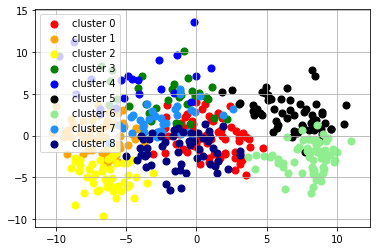

In [42]:
# Visualization
# Apply PCA for dimensionality reduction
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(featVecs)

colormaps = ["red", "orange", "yellow", "green", "blue", "black", 'lightgreen','dodgerblue','navy','mediumpurple','pink','hotpink','oldlace','aqua','slategrey','palegreen','m','indianred','orchid']

for iCluster in range(0, nClust):
    plt.scatter(principalComponents[y_km == iCluster, 0], principalComponents[y_km == iCluster, 1], s=50, c=colormaps[iCluster],  label='cluster '+ str(iCluster))
plt.legend(scatterpoints=1,loc='best')
plt.grid()
plt.show()

Hope you liked it! 
If you have any questions / suggestions, feel free to send me an email (adria.arbues@upf.edu) or a Twitter DM (@arbues6). 